# More Sophisticated Parameters

So far we have only considered constant parameter values. Now assume that we need to derive the value for a parameter based on some measurements we've made during the execution of previous parts of a composite pulse. For example, let the pulse we want to execute be constructed as follows:

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


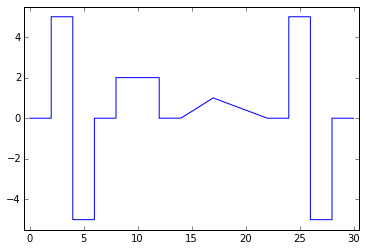

In [1]:
%matplotlib inline
from qctoolkit.pulses import TablePulseTemplate, SequencePulseTemplate, plot

init_template = TablePulseTemplate()
init_template.add_entry(2, 5)
init_template.add_entry(4, -5)
init_template.add_entry(6, 0)
init_template.add_entry(8, 0)

measurement_template = TablePulseTemplate(measurement=True)
measurement_template.add_entry(0, 2)
measurement_template.add_entry(4, 0)

dependent_template = TablePulseTemplate()
dependent_template.add_entry(2, 0)
dependent_template.add_entry(5, 'v', 'linear')
dependent_template.add_entry(10, 0, 'linear')

sequence_template = SequencePulseTemplate([(init_template, {}),
                                           (measurement_template, {}),
                                           (dependent_template, {'v': 'v'}),
                                           (init_template, {})
                                          ], {'v'})

plot(sequence_template, {'v': 1}, sample_rate=100)

Now we want to let the value of parameter `v` depend somehow on the measurement we make between time 8 and 12 (assuming we have a way to obtain measurement data, which is currently not the case (work in progress)). Thus we need to execute the first part of the pulse, then compute the parameter value and execute the remainder. We can do so be encapsulating the computation of the parameter value in a custom subclass of `Parameter`. Assuming, for simplicity, that we have some `measurement_manager` object which we can query whether or not the measurement has been made (`is_measurement_available()`) and what data was obtained (`get_data()`) and that the value of `v` shall simply be twice the measured data, this subclass might look like this:

In [2]:
from qctoolkit.pulses import Parameter

class MeasurementDependentParameter:
    
    def __init__(self, measurement_manager) -> None:
        self.measurement_manager = measurement_manager
    
    @property
    def requires_stop(self) -> bool:
        return not self.measurement_manager.is_measurement_available()
        
    def get_value(self) -> float:
        return 2*(self.measurement_manager.get_data())

We overwrite the abstract property `requires_stop` and the abstract method `get_value` of the `Parameter` base class. `requires_stop` is used to indicate to the `Sequencer` whether the `Parameter` object can currently be evaluated or whether the sequencing process has to be interrupted. Our `MeasurementDependentParameter` will return `True` if no measurement data is available (in contrast, the `ConstantParameter` - which internally represents any float value passed in - always returns `False`). The `get_value` method returns the parameter value. It is only called if `requires_stop` is false. In the `MesaurementDependentParameter` class, we assume that the measured data is a single float and that we simple want to multiply it by 2 as the parameter's value.

We would then set up our pulse for execution like as in the following snippet (including a stub implementation of a `MeasurementManager` just for demonstration purposes):

In [7]:
from qctoolkit.pulses import Sequencer

# We define a stub for the measurement manager here only for illustration purposes.
# It will state that a measurement is available iff Sequencer has interrupted its operation
class MeasurementManager:
    def __init__(self, sequencer: Sequencer) -> None:
        self.sequencer = sequencer
        self.call_count = 0
        
    def is_measurement_available(self) -> bool:
        is_available = self.call_count > 0
        self.call_count += 1
        return is_available
    
    def get_data(self) -> float:
        return 3

sequencer = Sequencer()
measurement_manager = MeasurementManager(sequencer)
parameter = MeasurementDependentParameter(measurement_manager)

sequencer.push(init_template)
sequencer.push(dependent_template, {'v': parameter})
sequencer.push(measurement_template)
sequencer.push(init_template)

The `MeasurementManager.is_measurement_available` stub will simply return `False` in the first invocation of `Sequencer.build` and `True` iff the `Sequencer` was interrupted before, simulating that some data is measured during the execution of the first part of the pulse.

When we invoke `Sequencer.build`, for each template on the sequencing stack it first queries whether or not all parameters can be evaluated. If any of them returns `True` via the `requires_stop` method, the sequencing process will be interrupted.
In our example, `Sequencer` will first proceed through the first two subtemplates of `sequence_template`. When it arrives at `dependent_template`, it will stop:

In [8]:
first_sequence = sequencer.build()
print(first_sequence)

TypeError: float() argument must be a string or a number, not 'MeasurementDependentParameter'